In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

input_data="C:\\Users\\yolan\\Documents\\dataanalytics.predictive\\data\\input.csv"
input_data = pd.read_csv(input_data, delimiter=";", parse_dates=['FECHA'])
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57620 entries, 0 to 57619
Data columns (total 32 columns):
ID_SEGMENT            57620 non-null int64
COD_LABORALIDAD       57620 non-null int64
FECHA                 57620 non-null datetime64[ns]
MES                   57620 non-null int64
HORA                  57620 non-null int64
MINUTO                57620 non-null int64
CANTIDAD_PREC         57620 non-null float64
TOTAL_VEHICULOS       57620 non-null int64
TOTAL_VEHICULOS_1     57620 non-null int64
TOTAL_VEHICULOS_2     57620 non-null int64
TOTAL_VEHICULOS_3     57620 non-null int64
TOTAL_VEHICULOS_4     57620 non-null int64
TOTAL_VEHICULOS_5     57620 non-null int64
TOTAL_VEHICULOS_6     57620 non-null int64
TOTAL_VEHICULOS_7     57620 non-null int64
TOTAL_VEHICULOS_8     57620 non-null int64
TOTAL_VEHICULOS_9     57620 non-null int64
TOTAL_VEHICULOS_10    57620 non-null int64
TOTAL_VEHICULOS_11    57620 non-null int64
TOTAL_VEHICULOS_12    57620 non-null int64
TOTAL_VEHICULOS_13  

In [2]:
from datetime import timedelta

start_date = min(pd.to_datetime(input_data['FECHA']))
end_date = max(pd.to_datetime(input_data['FECHA']))

total_days = (end_date-start_date).days
print("Start Date: " + str(start_date) + "\n" + "End Date: " + str(end_date))
print("Number of days in the dataset: " + str(total_days))

split_factor = .75 
split_day = start_date +  timedelta(days=int(total_days)*split_factor)

print("Starting Test Day: " + str(split_day))

Start Date: 2019-01-01 00:00:00
End Date: 2019-01-31 00:00:00
Number of days in the dataset: 30
Starting Test Day: 2019-01-23 12:00:00


## Pruebas con segmento 1

In [36]:
input_data_1 = input_data.loc[input_data['ID_SEGMENT']==1]

In [37]:
# Create training and test data
input_data_1['is_train'] = input_data_1['FECHA'] < split_day
train, test = input_data_1[input_data_1['is_train']==True], input_data_1[input_data_1['is_train']==False]
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))
train.index=pd.to_datetime(train['FECHA'])
test.index=pd.to_datetime(test['FECHA'])

Number of observations in the training data: 2160
Number of observations in the test data: 721


C:\Users\yolan\Anaconda3\envs\dataanalytics.predictive\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


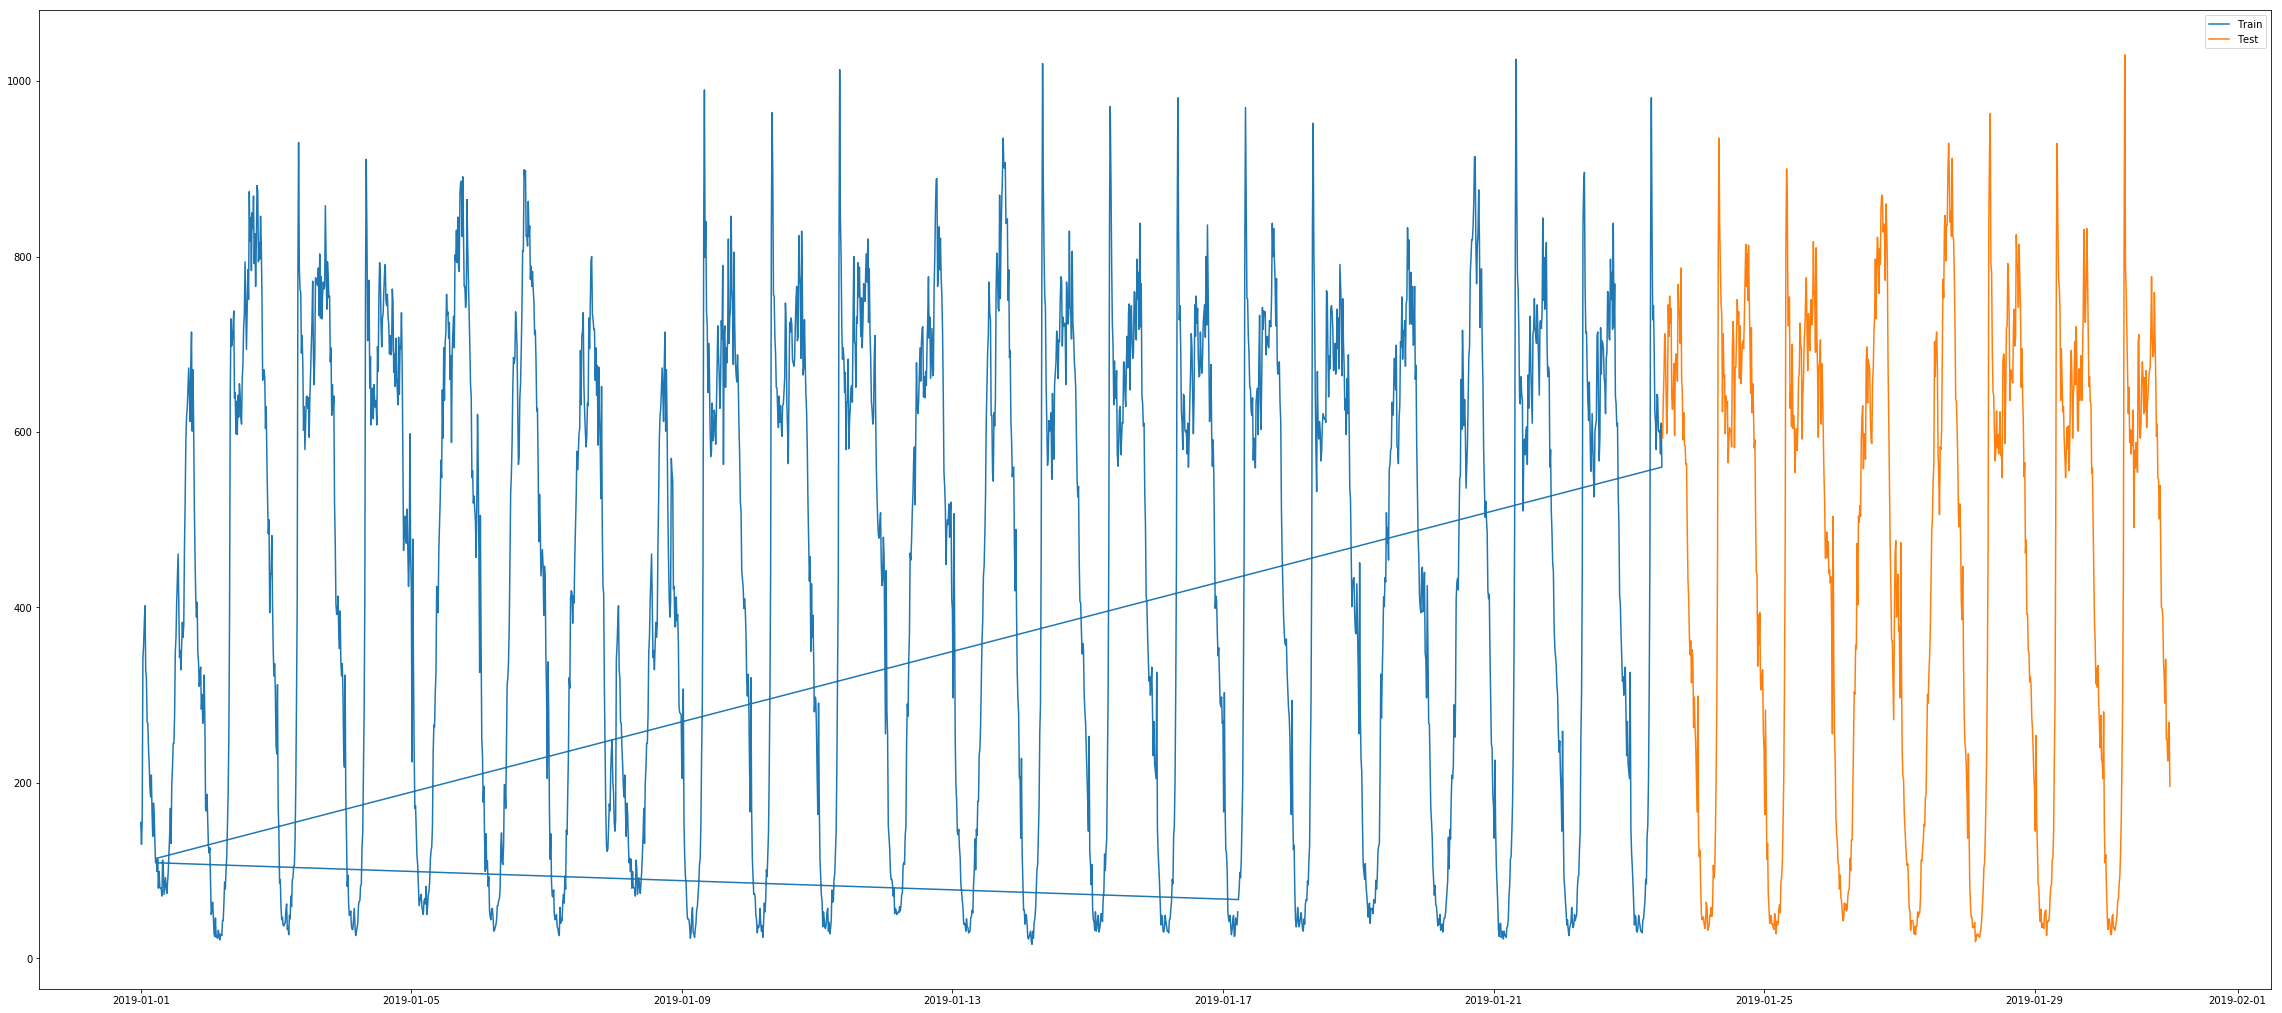

In [38]:
plt.figure(figsize=(40,18))
plt.plot(train.index, train.TOTAL_VEHICULOS, label='Train')
plt.plot(test.index, test.TOTAL_VEHICULOS, label='Test')
plt.legend(loc='best')
plt.show()

## Simple Exp Smoothing

In [39]:
from statsmodels.tsa.api import ExponentialSmoothing

### Prueba 1 - smoothing_level=0.5, smoothing_seasonal=0.5

In [46]:
train_day = train.loc[train['FECHA']>split_day - timedelta(days=7)] # one week in training
y_hat_avg = test.loc[test['FECHA']<split_day + timedelta(days=1)].copy() # one day in testing

In [47]:
exp_fit1 = ExponentialSmoothing(np.asarray(train_day['TOTAL_VEHICULOS']), seasonal_periods=96, seasonal='add',).fit(smoothing_level=0.5)

In [48]:
y_hat_avg['ES_1'] = exp_fit1.forecast(len(y_hat_avg))

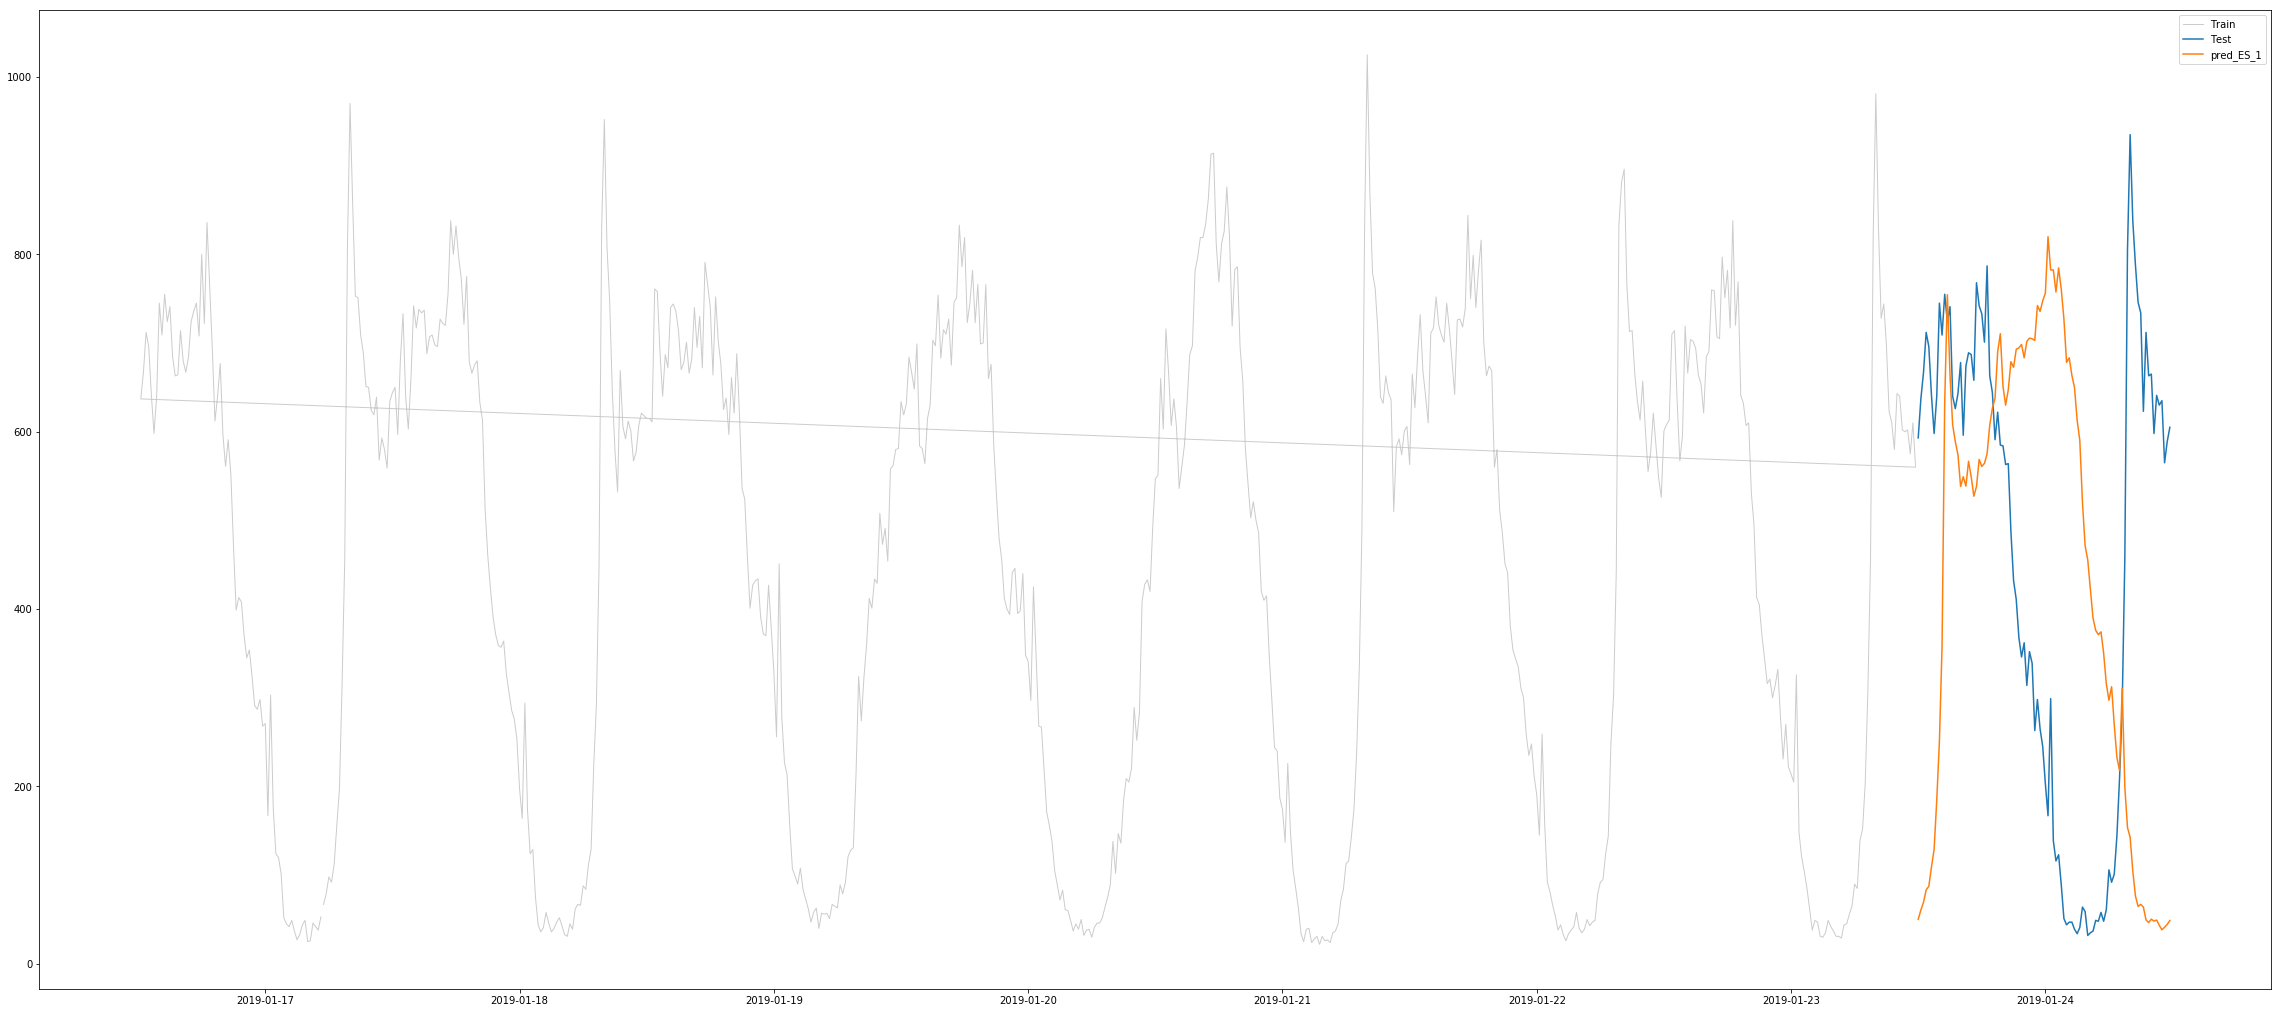

In [49]:
plt.figure(figsize=(40,18))
plt.plot(train_day.index, train_day.TOTAL_VEHICULOS, label='Train', marker='', color='grey', linewidth=1, alpha=0.4)
plt.plot(y_hat_avg.index, y_hat_avg.TOTAL_VEHICULOS, label='Test')
plt.plot(y_hat_avg.index, y_hat_avg.ES_1, label='pred_ES_1')
plt.legend(loc='best')
plt.show()


### Prueba 2 - smoothing_level=0.5, smoothing_seasonal=0.5

In [67]:
# smoothing_level=0.5, smoothing_seasonal=0.5
fit2 = ExponentialSmoothing(np.asarray(train_day['TOTAL_VEHICULOS']), seasonal_periods=96, seasonal='add',).fit(smoothing_level=0.5, smoothing_seasonal=0.5)

In [68]:
y_hat_avg['ES_2'] = fit2.forecast(len(y_hat_avg))

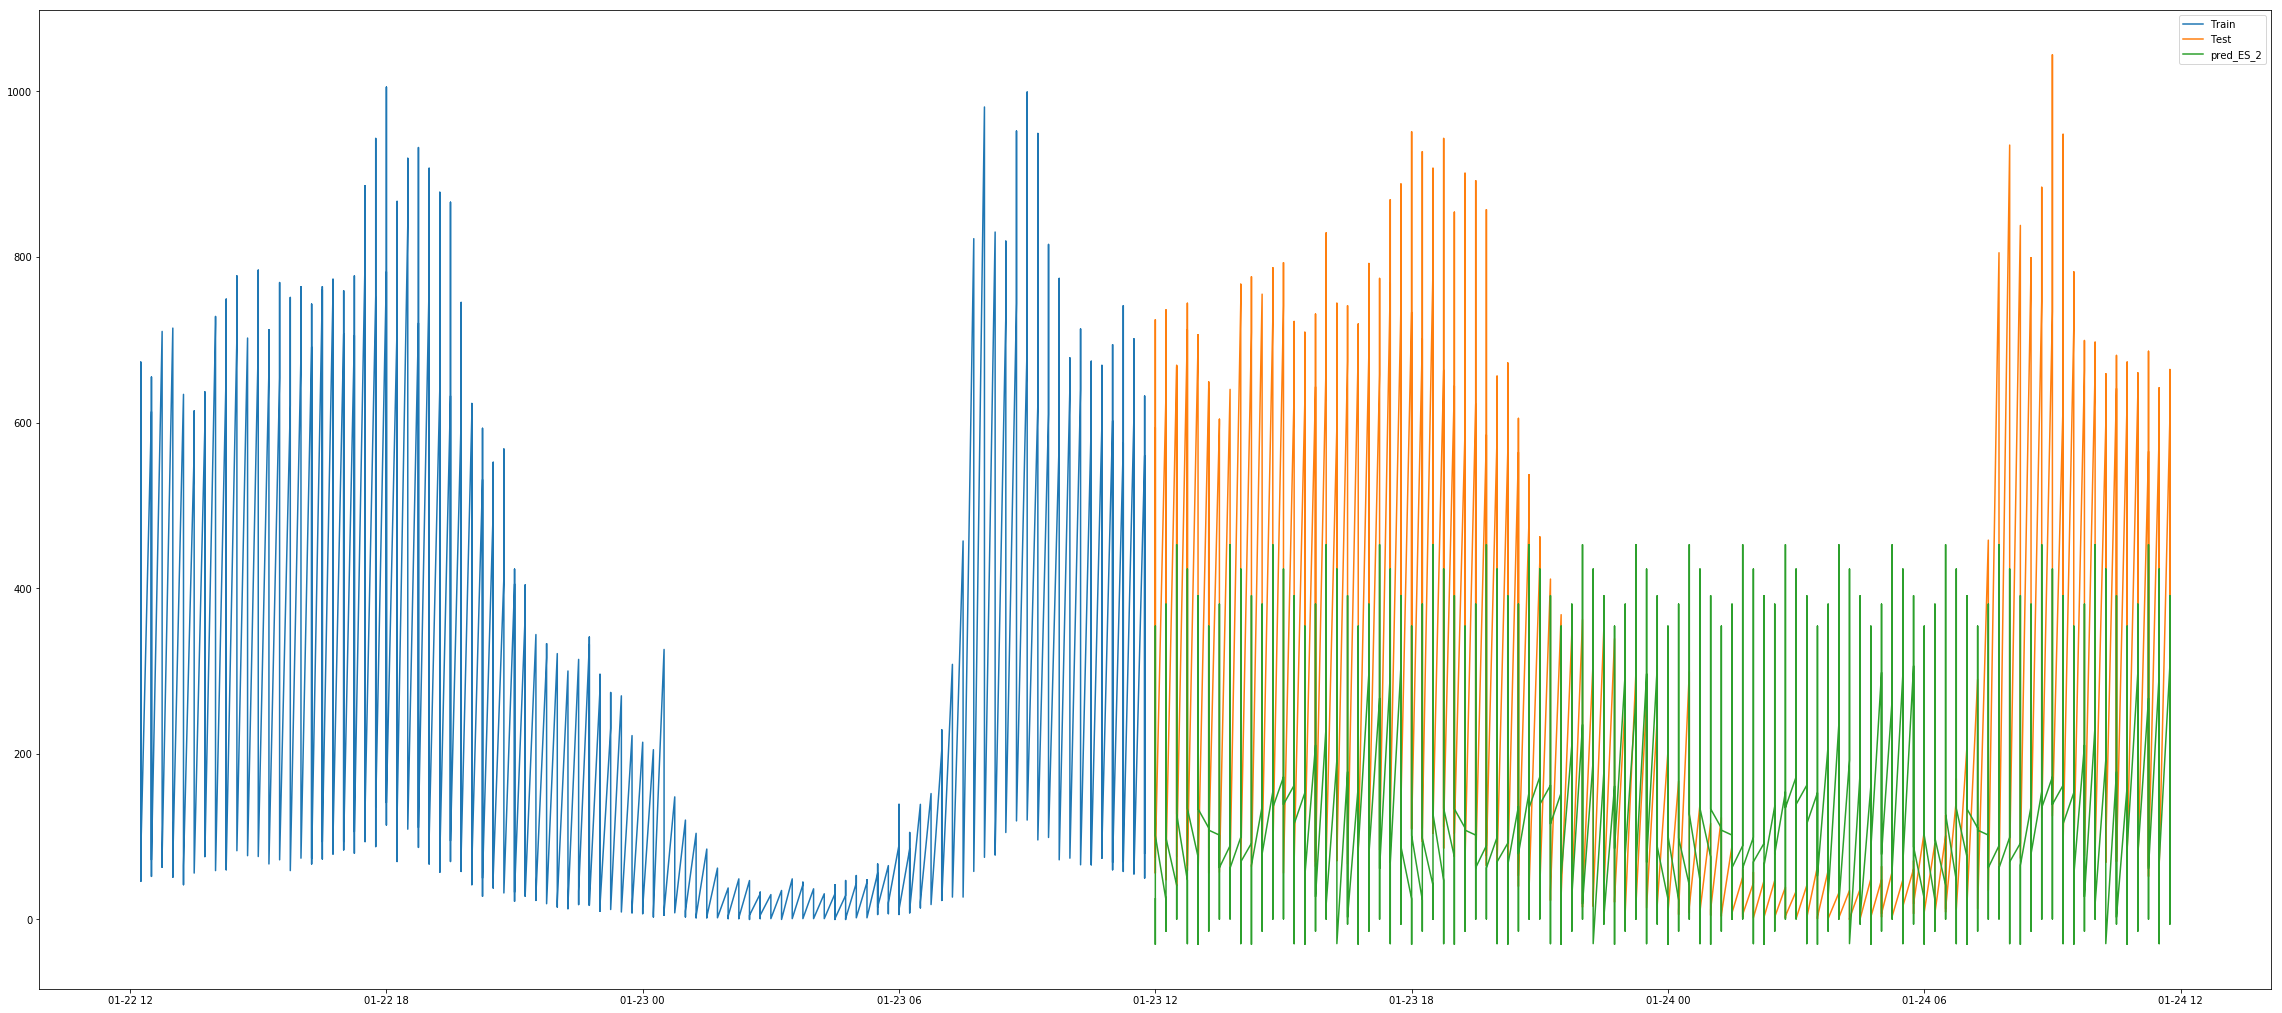

In [69]:
plt.figure(figsize=(40,18))
plt.plot(train_week.index, train_week.TOTAL_VEHICULOS, label='Train')
plt.plot(y_hat_avg.index, y_hat_avg.TOTAL_VEHICULOS, label='Test')
plt.plot(y_hat_avg.index, y_hat_avg.ES_2, label='pred_ES_2')
plt.legend(loc='best')
plt.show()

In [70]:
#smoothing_level=0.1, smoothing_seasonal=0.5

fit3 = ExponentialSmoothing(np.asarray(train_day['TOTAL_VEHICULOS']), seasonal_periods=96, seasonal='add',).fit(smoothing_level=0.8, smoothing_seasonal=0.8)

In [71]:
y_hat_avg['ES_3'] = fit3.forecast(len(y_hat_avg))

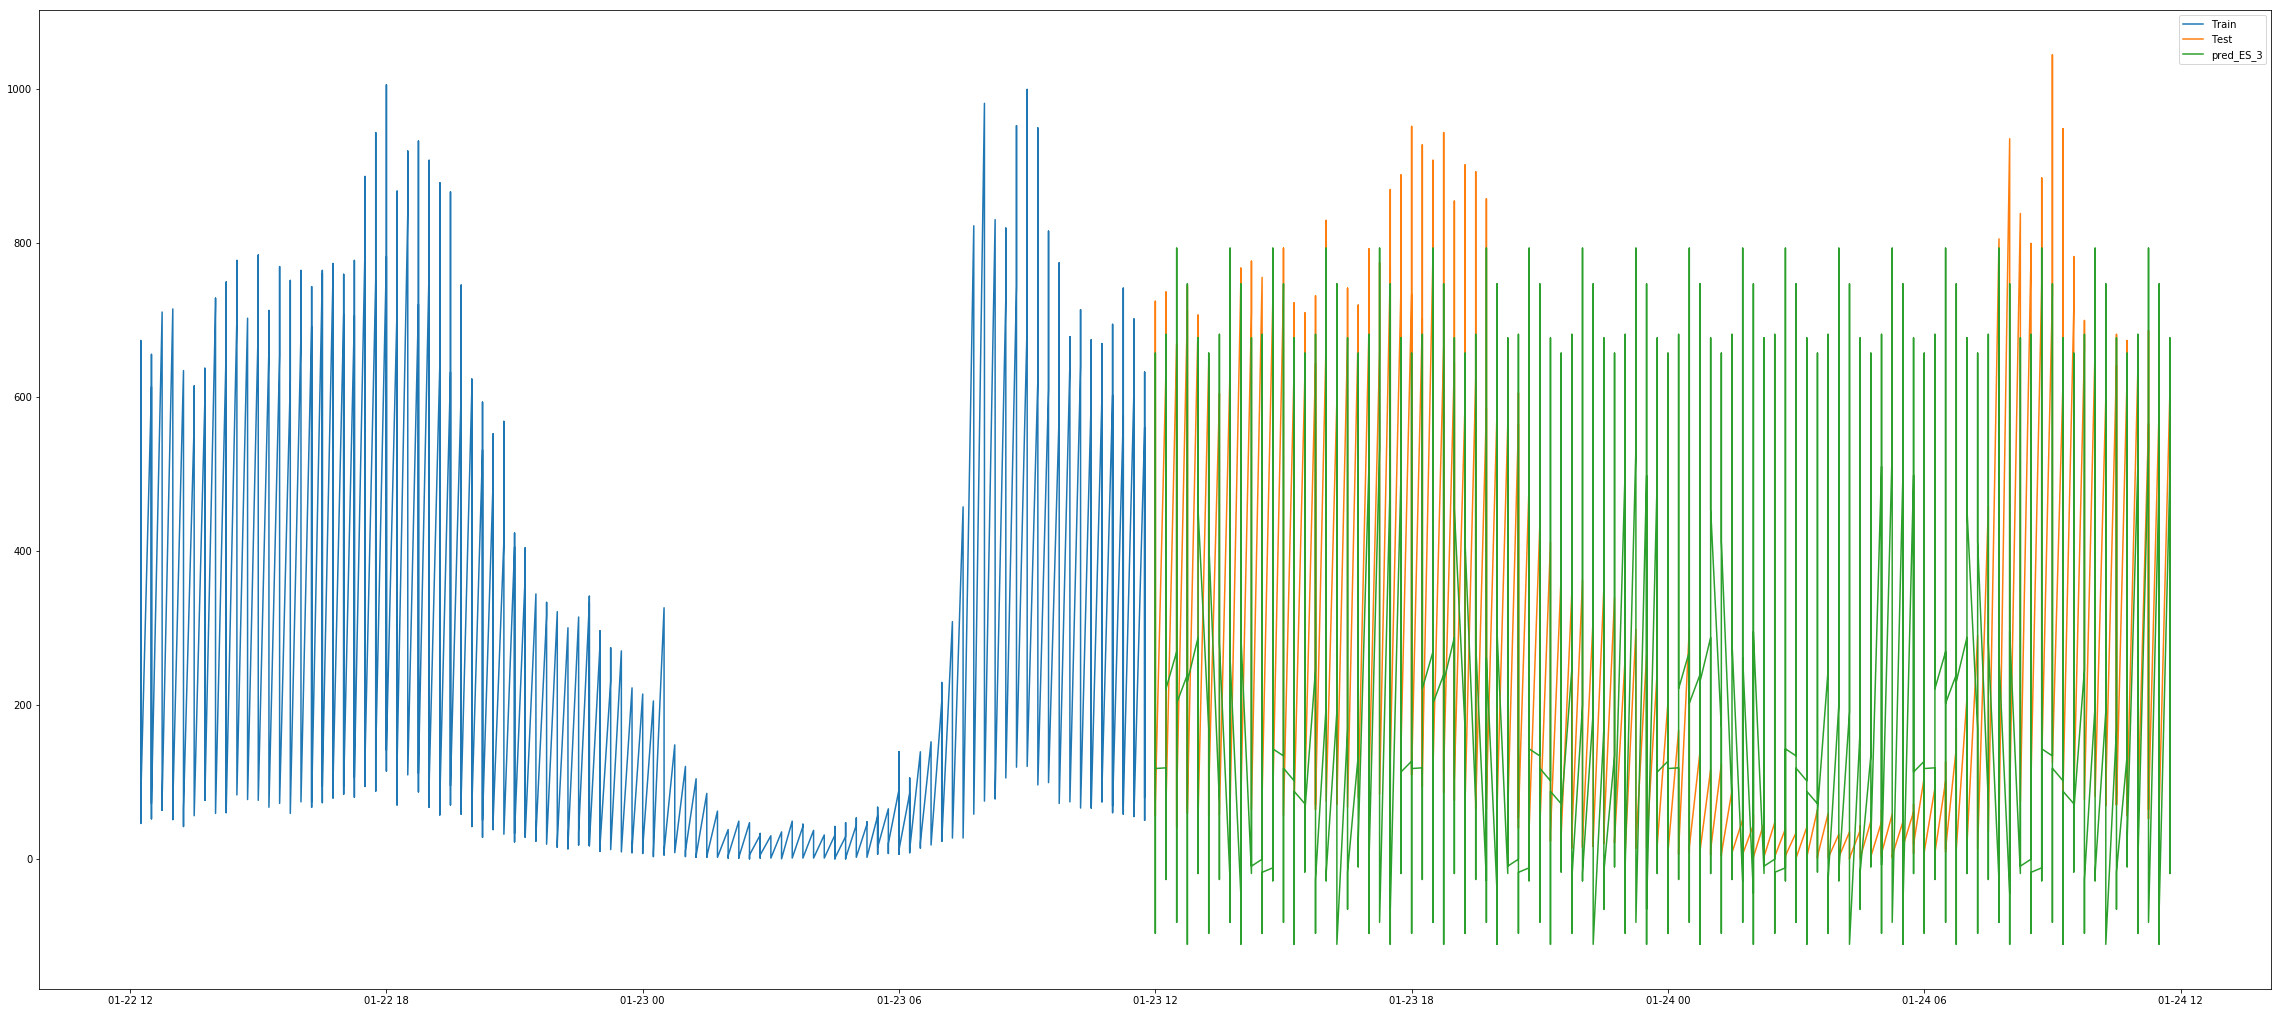

In [72]:
plt.figure(figsize=(40,18))
plt.plot(train_week.index, train_week.TOTAL_VEHICULOS, label='Train')
plt.plot(y_hat_avg.index, y_hat_avg.TOTAL_VEHICULOS, label='Test')
plt.plot(y_hat_avg.index, y_hat_avg.ES_3, label='pred_ES_3')
plt.legend(loc='best')
plt.show()

## SARIMAX

In [74]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [82]:
arima1 = sm.tsa.statespace.SARIMAX(np.asarray(train_day['TOTAL_VEHICULOS']), trend='ct', order=(1, 1, 1), seasonal_order=(1, 1, 1, 96), enforce_stationarity=False, enforce_invertibility=False).fit()

C:\Users\yolan\Anaconda3\envs\dataanalytics.predictive\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [83]:
y_hat_avg['SARIMA_1'] = arima1.forecast(steps=len(y_hat_avg))

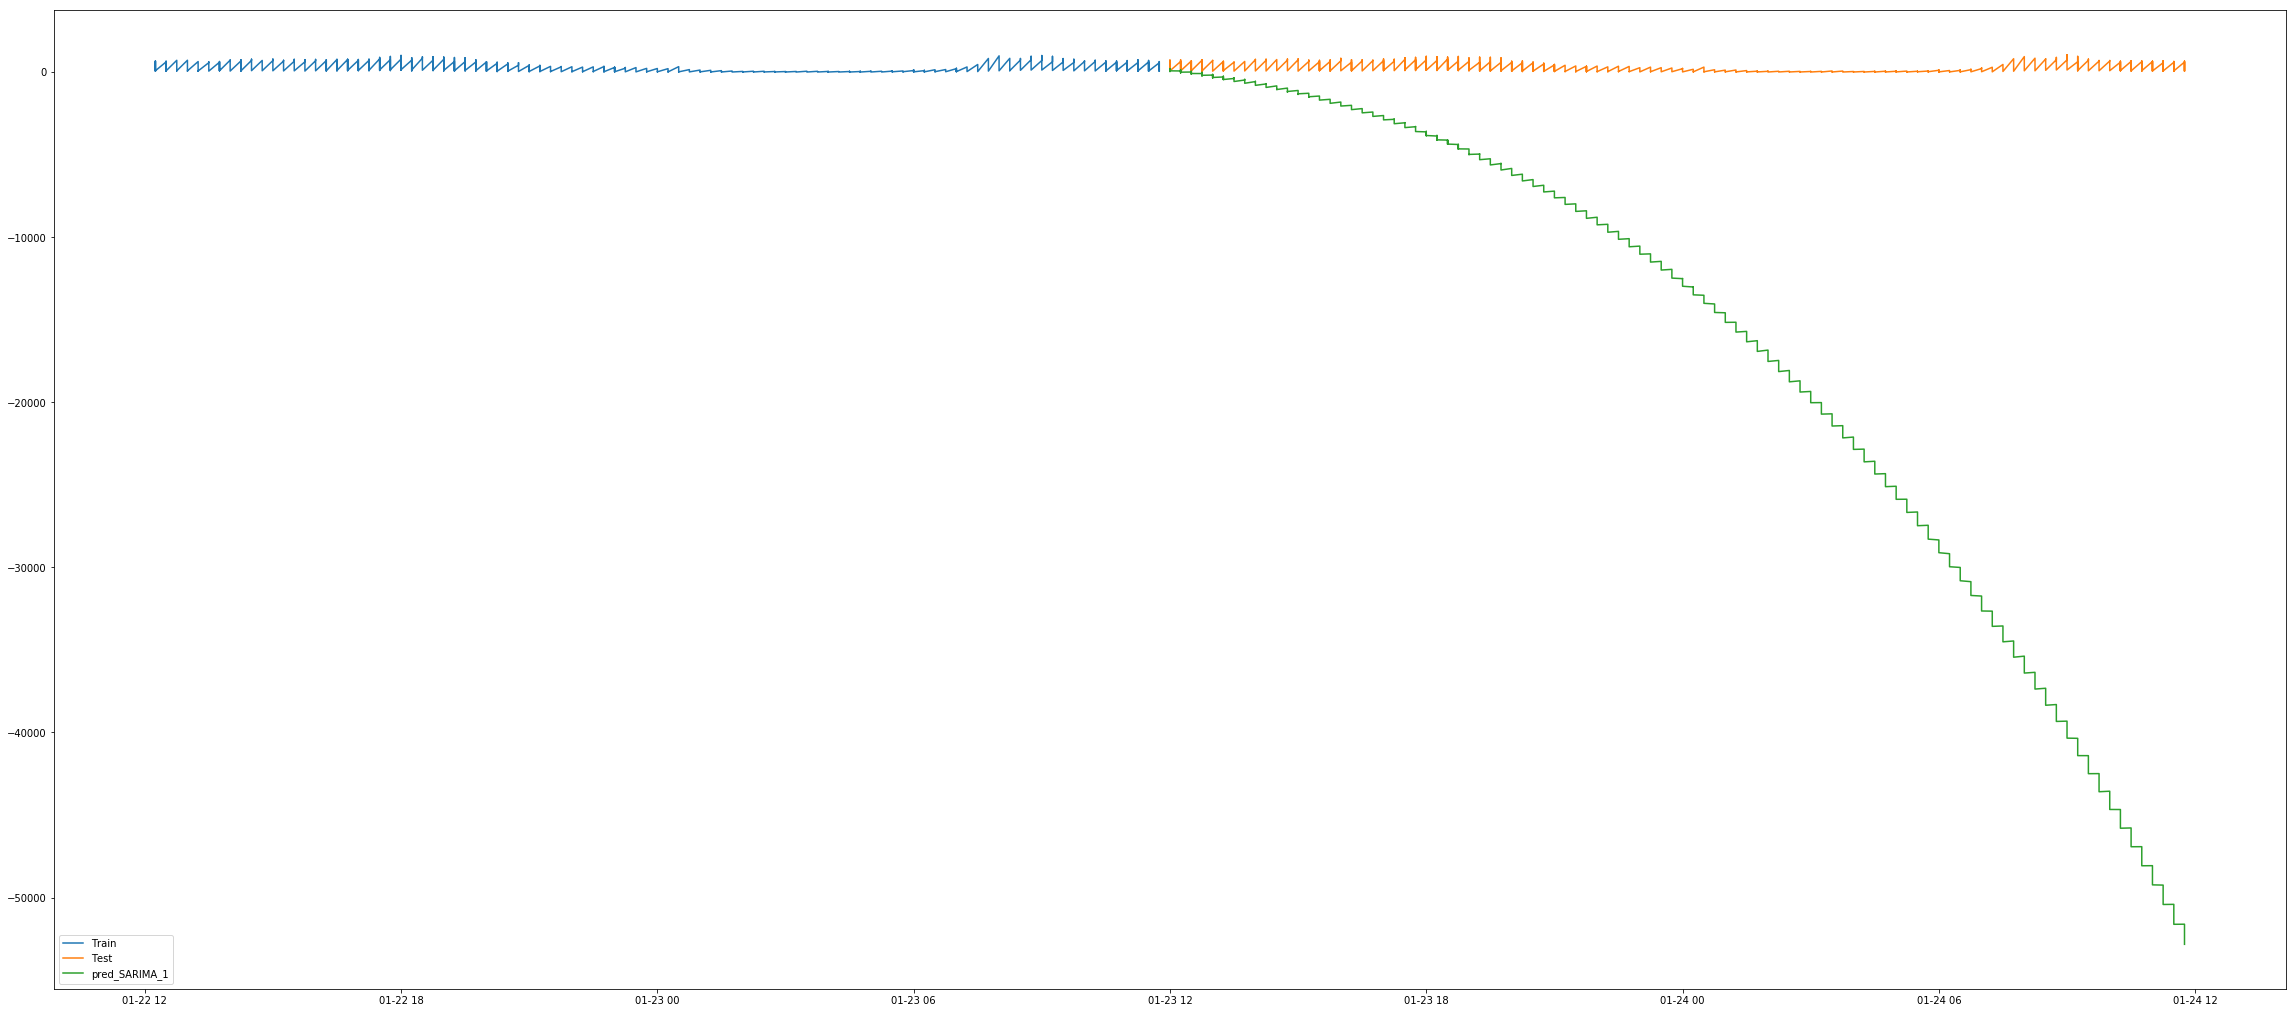

In [84]:
plt.figure(figsize=(40,18))
plt.plot(train_week.index, train_week.TOTAL_VEHICULOS, label='Train')
plt.plot(y_hat_avg.index, y_hat_avg.TOTAL_VEHICULOS, label='Test')
plt.plot(y_hat_avg.index, y_hat_avg.SARIMA_1, label='pred_SARIMA_1')
plt.legend(loc='best')
plt.show()

## FBPROPHET